In [39]:
# importing packages

import pandas as pd
from prophet import Prophet
from datetime import datetime, timedelta
from sklearn.metrics import mean_absolute_percentage_error

In [40]:
# loading the data from csv file

# this csv file is generated using the Rmd file. Upload it into the session storage
# before reading it.
sector_stats = pd.read_csv('yearly_sector_stats.csv')

# removing index column

sector_stats = sector_stats.iloc[:, 1:]

# The funding information for certain years of some sectors are not available. There are
# 2 possible scenarios:-
#   i. Those sectors did not receive any funding in those years (i.e Amount.Awarded is zero)
#   ii. Those sectors received funding but the information is missing


In [41]:
# Run this cell if you want to add the missing years with zero values for the
# amount and grants given. Otherwise, you can directly go and run the next cell.
# Running his cell will result in the increase of the mean absolute percentage
# loss compared when this cell is not run


# the data given has years from 2010 to 2022
# the aim is to predict values for 2023
# some of the sectors have missing values in the range given
# so adding rows with amount 0 correspondin to the missing years

year_range = list(range(2010, 2023))
sectors = sector_stats['Sector'].unique()

# creating a dataframe to store the missing rows
missing_years_rows = sector_stats.iloc[:0, :].copy()

# looping through the sectors to find the missing years for each sector
for sector in sectors:
  # years in the current sector
  award_years = sector_stats.query('Sector == @sector')['Award.Year']
  last_matching_index = 0
  for yr in award_years:
    current_matching_index = year_range.index(yr)
    if current_matching_index == last_matching_index:
      last_matching_index += 1
    else:
      # adding the missing year rows with amount and grants as 0
      missing_years_rows = pd.concat([missing_years_rows,
                                pd.DataFrame({'Sector': sector,
          'Award.Year': year_range[last_matching_index:current_matching_index],
          'Total.Amount.Awarded': 0, 'Total.Grants.Given': 0})])
      last_matching_index = current_matching_index + 1

  # the above loop will only handle missing years till the last year in the 
  # particular sector. If the last year is before 2022, then years till 2022
  # will not be added. The following code is to handle that.
  if last_matching_index < len(year_range):
    missing_years_rows = pd.concat([missing_years_rows, pd.DataFrame({
        'Sector': sector, 'Award.Year': year_range[last_matching_index:],
        'Total.Amount.Awarded': 0, 'Total.Grants.Given': 0
    })])


# The missing values are added to end of the existing dataframe
sector_stats = pd.concat([sector_stats, missing_years_rows], ignore_index = True)
# the dataframe is sorted by sector and award year
sector_stats.sort_values(by = ['Sector', 'Award.Year'], inplace = True,
                         ignore_index = True)


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 9.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcrjjq_68/qqdnkek1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcrjjq_68/8jpov55m.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=16844', 'data', 'file=/tmp/tmpcrjjq_68/qqdnkek1.json', 'init=/tmp/tmpcrjjq_68/8jpov55m.json', 'output', 'file=/tmp/tmpcrjjq_68/prophet_modelnfpzfkiu/prophet_model-20230203141054.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
14:10:54 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
14:10:54 - cmdstanpy - INFO - Chain [1] done processing
INFO:cm

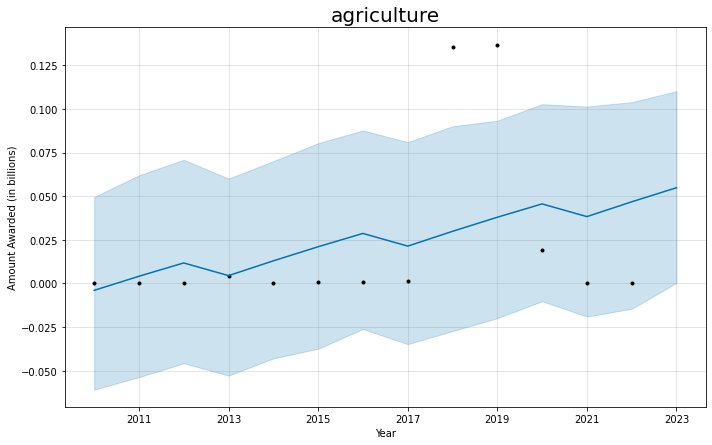

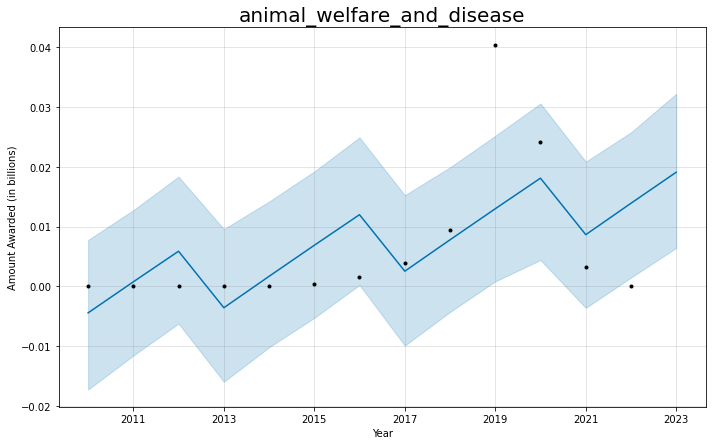

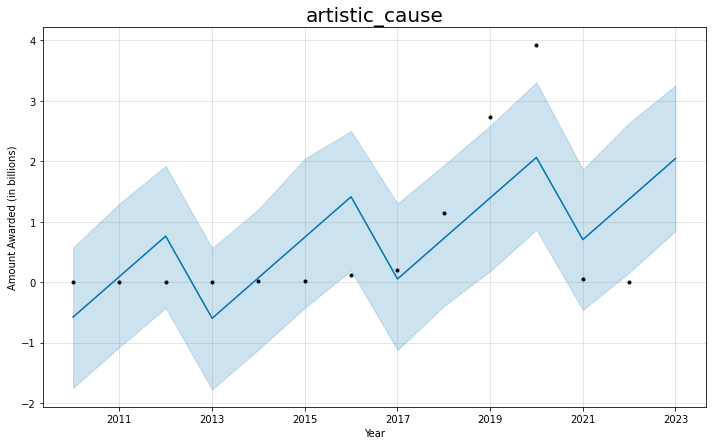

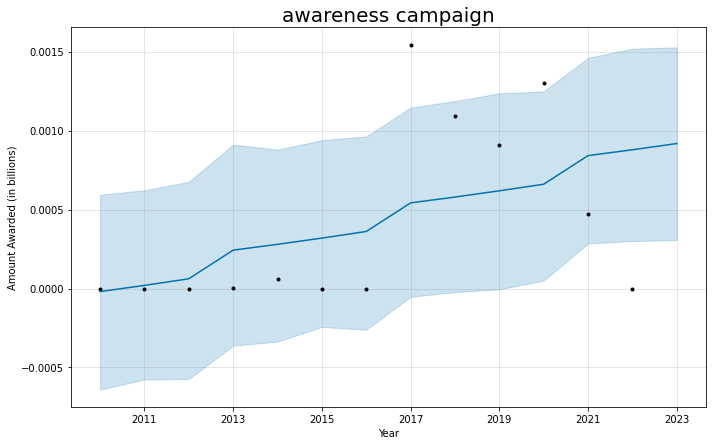

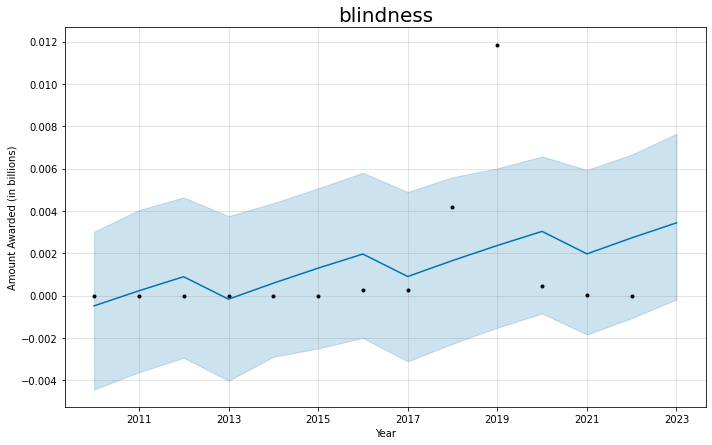

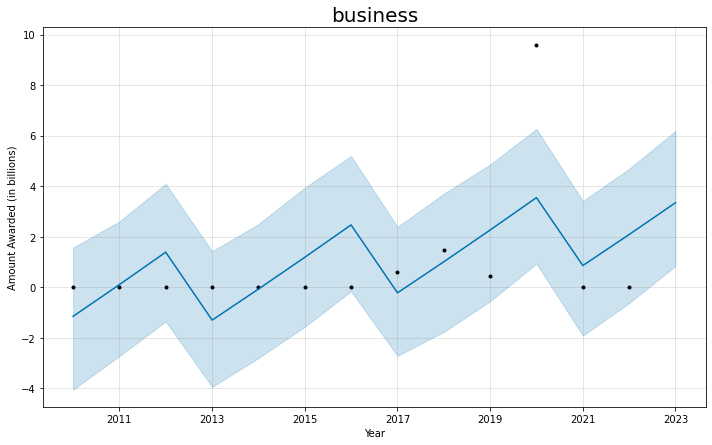

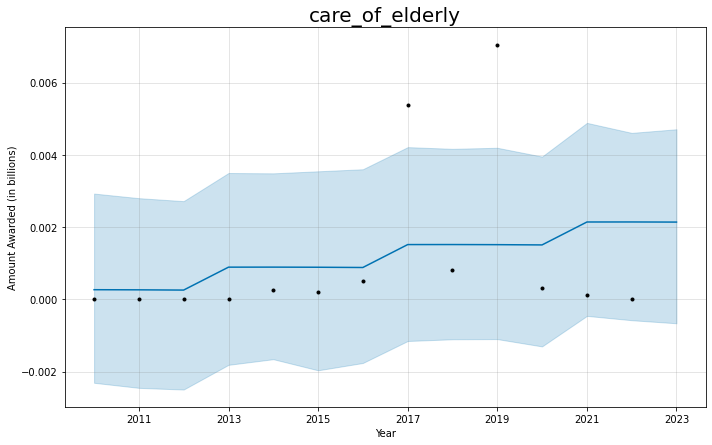

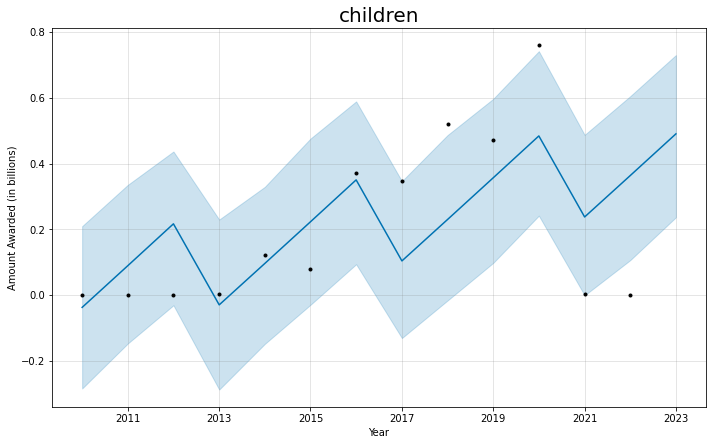

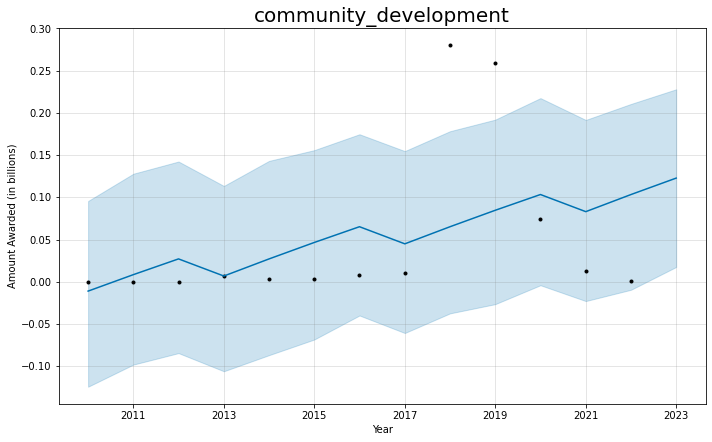

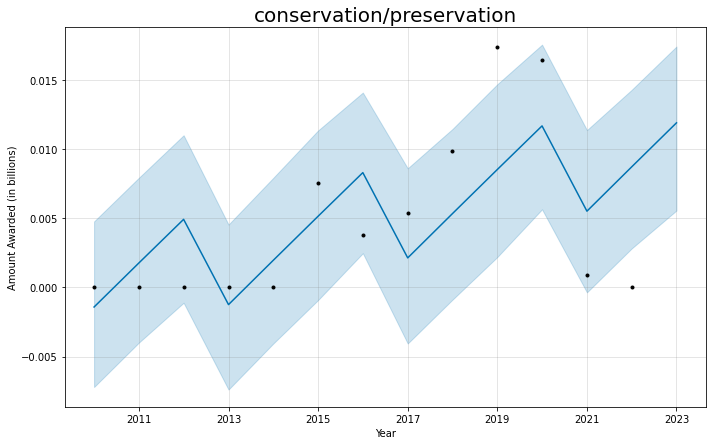

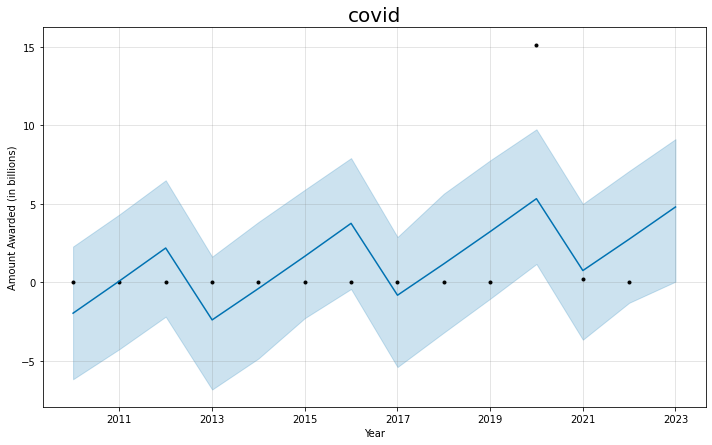

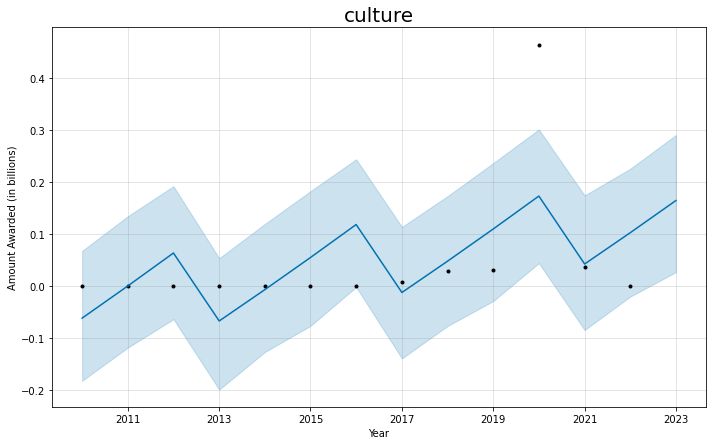

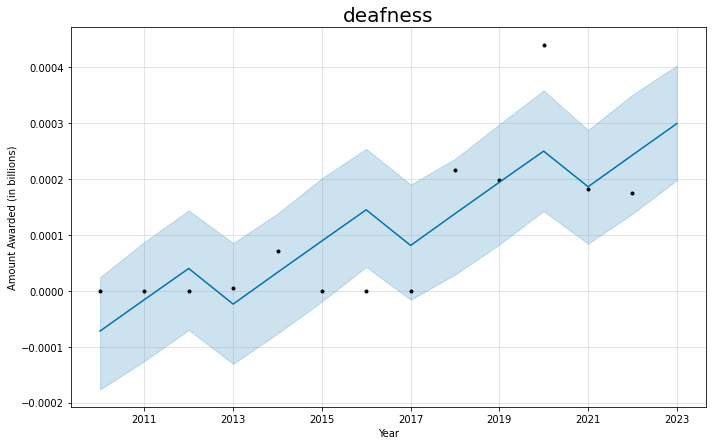

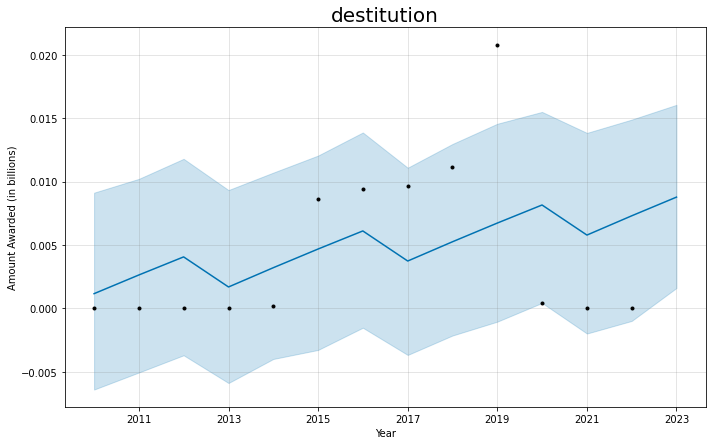

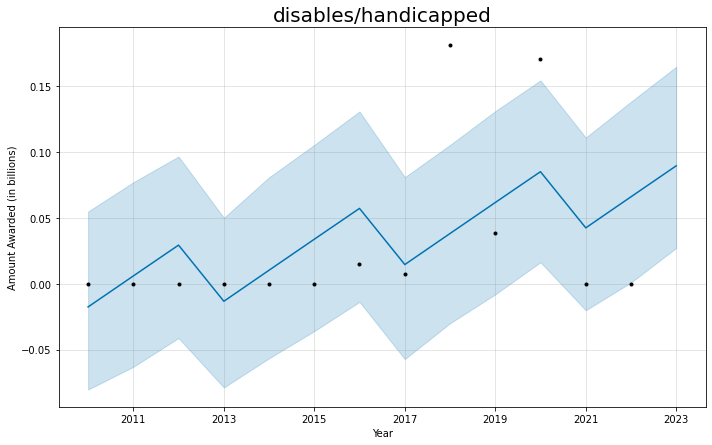

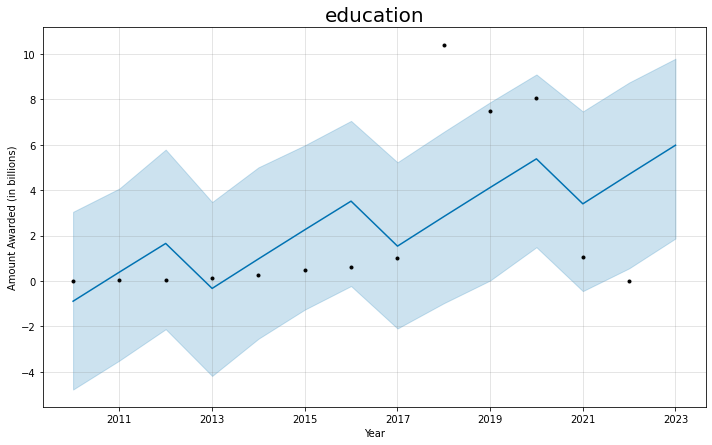

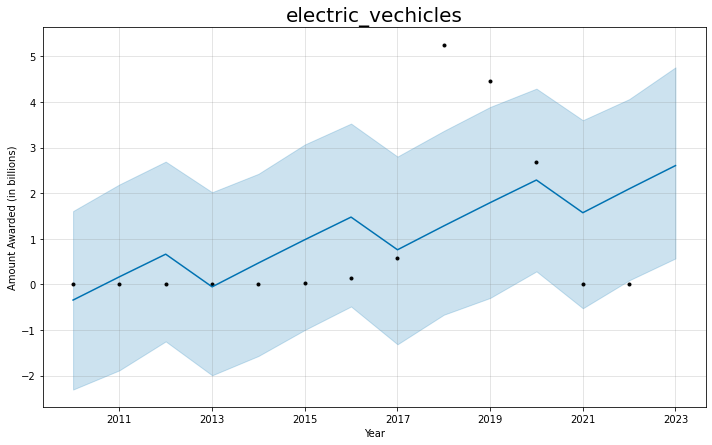

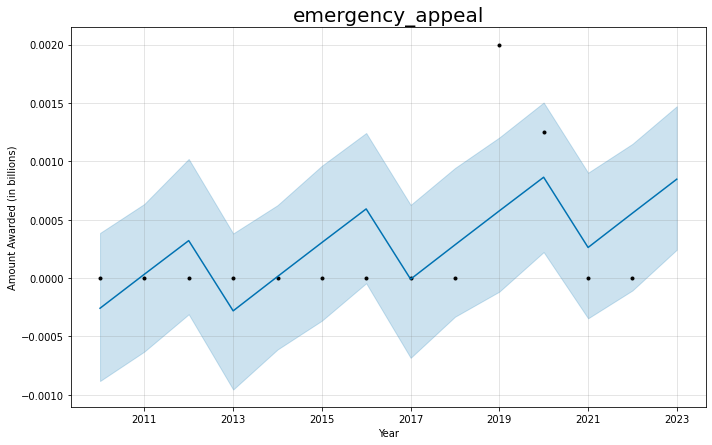

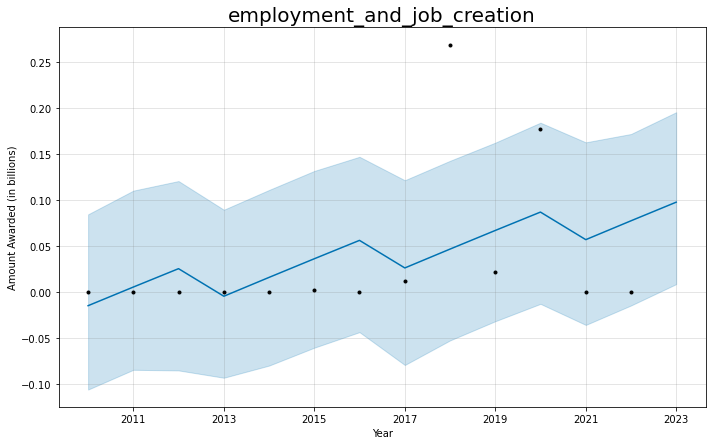

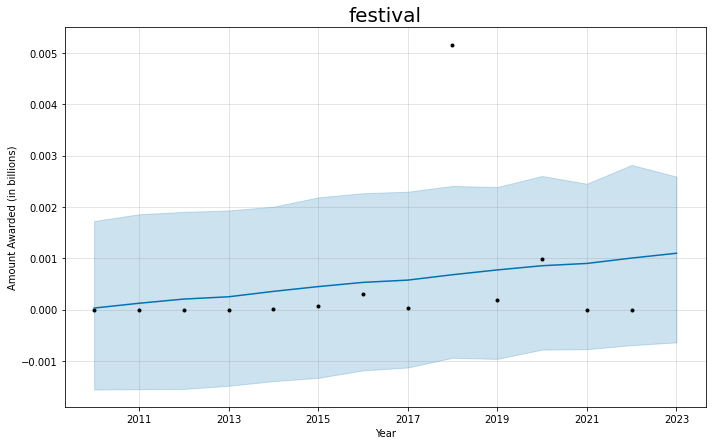

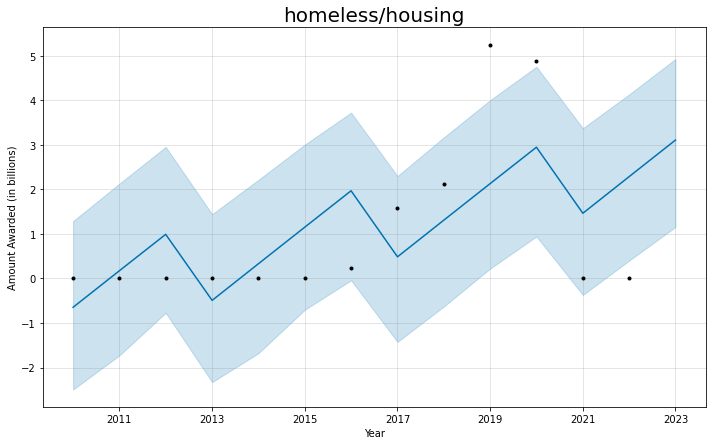

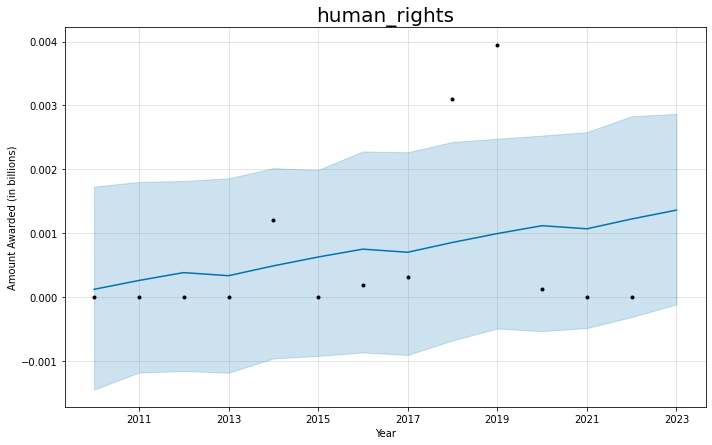

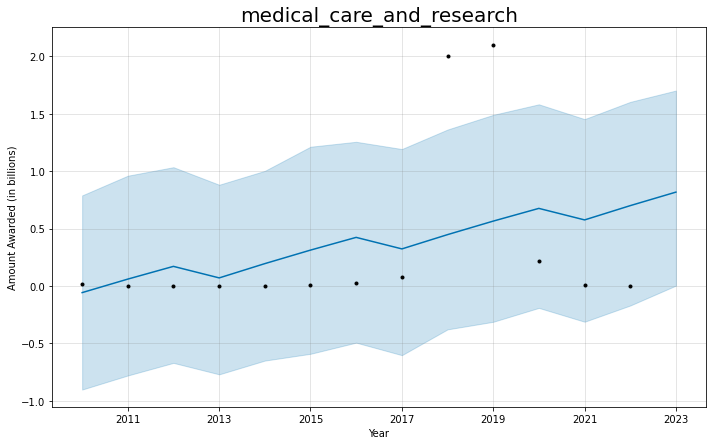

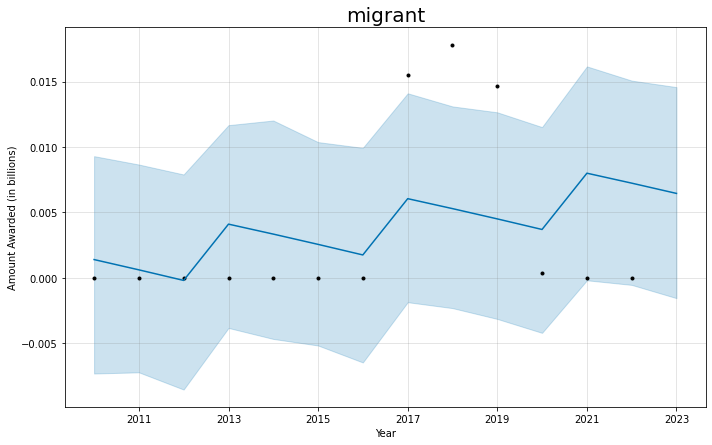

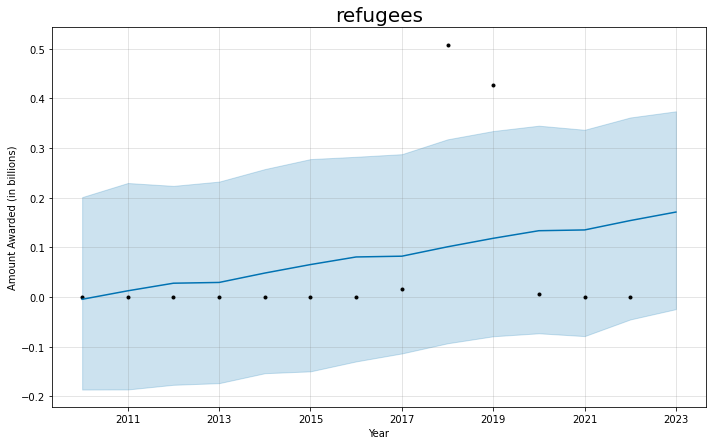

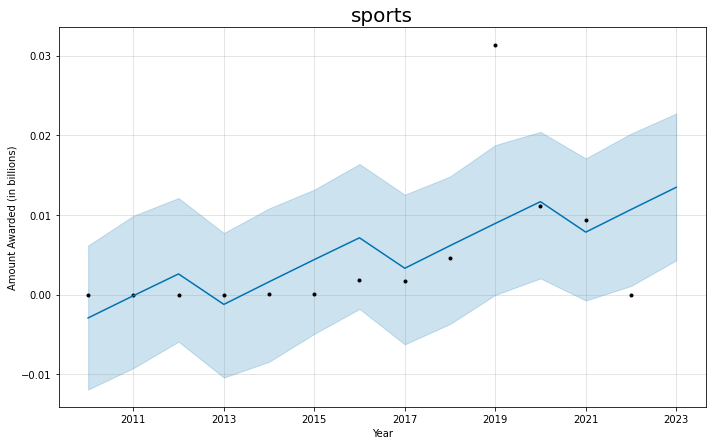

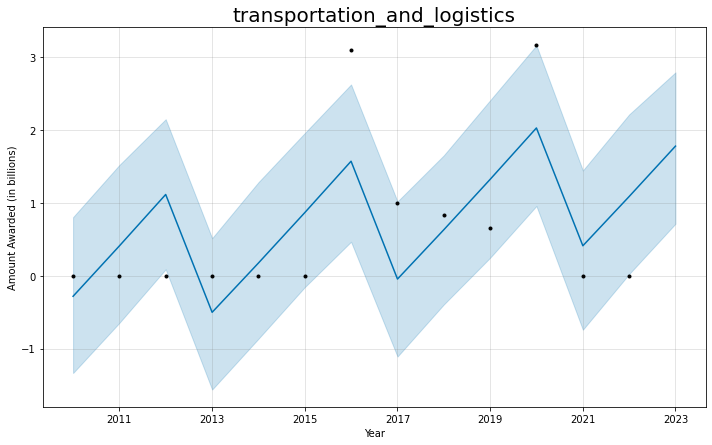

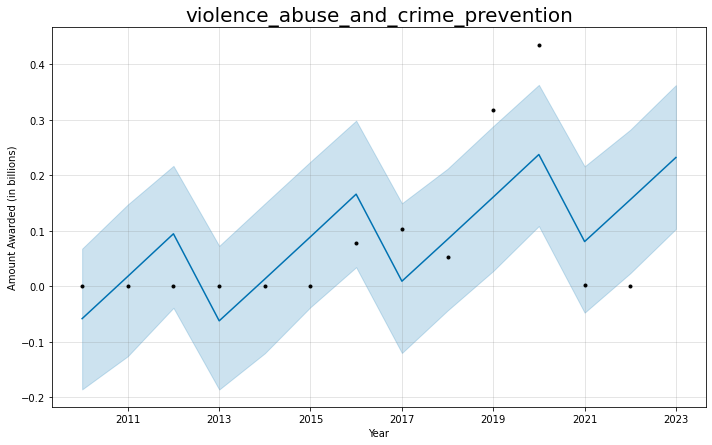

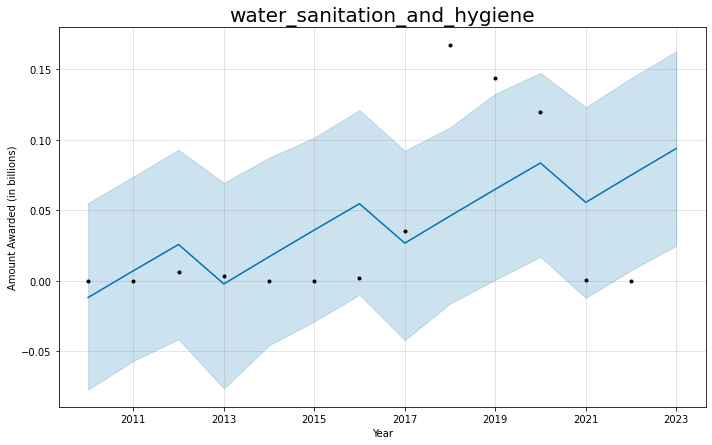

In [42]:
# dataframe to store the predicted values
predicted_stats = pd.DataFrame(columns = ['Sector', 'Award.Date', 'Amount.Awarded',
                                          'Amount.Predicted', 'Amount.Predicted.Lower',
                                          'Amount.Predicted.Upper'])

# regression loss for sectors
loss_stats = pd.DataFrame(columns = ['Sector', 'Mean.Absolute.Percentage.Loss'])

# looping through the data frame to extract data for each sector
for sector in sector_stats['Sector'].unique():

  # fetching the year and award amount for each sector
  df = sector_stats.query('Sector == @sector')[['Award.Year',
                                                'Total.Amount.Awarded']]
  # converting award year to datetime
  df['Award.Year'] = df['Award.Year'].map(lambda y: datetime(y,1,1))
  # renaming the columns to match prophet input
  df.columns = ['ds', 'y']

  # creating Prophet object and fitting the data
  m = Prophet()
  m.fit(df)

  # generating a series of dates
  # this consists of all dates in the dataframe and a new date which is one year
  # ahead of the last date in the data frame

  future = m.make_future_dataframe(periods = 1, freq = 'Y')
  # when using make_future_dataframe with freq as year, then next date generated
  # is the end of the last year. Since we start with the first day of first month,
  # we will get the last day of the last month as the last date in the generated series.
  # Thus adding one more day to the last date to make it one year ahead for the 
  # second last date generated
  future.iloc[-1] += timedelta(days = 1)

  # predicting the future and history values
  forecast = m.predict(future)

  # calculating the mean absolute percentage loss for each sector
  mean_error = mean_absolute_percentage_error(df.y, forecast['yhat'].iloc[:-1])
  error_df = pd.DataFrame({'Sector': sector,
          'Mean.Absolute.Percentage.Loss': [mean_error]})
  loss_stats = pd.concat([loss_stats, error_df], ignore_index = True)
  # loss_stats = pd.concat([loss_stats, pd.DataFrame({'Sector': sector,
  #         'Mean.Absolute.Percentage.Error': mean_absolute_percentage_error(df.y,
  #                                                 forecast['yhat'].iloc[:-1])})],
  #                        ignore_index = True)

  # sector based predictions
  predictions = pd.DataFrame({'Sector': sector, 'Award.Date': future.ds, 
    'Amount.Awarded': pd.concat([df.y, pd.Series(forecast['yhat'].iat[-1])],
                                ignore_index = True),
    'Amount.Predicted': forecast['yhat'],
    'Amount.Predicted.Lower': forecast['yhat_lower'],
    'Amount.Predicted.Upper': forecast['yhat_upper']})
  
  # appending the sector predictions to the main output dataframe
  predicted_stats = pd.concat([predicted_stats, predictions], ignore_index = True)

  # plotting forecasts
  fig = m.plot(forecast, xlabel='Year', ylabel='Amount Awarded (in billions)')
  ax = fig.gca()
  ax.set_title(sector, size=20)
  # ax.set_xlabel("X", size=34)
  # ax.set_ylabel("Y", size=34)
  # ax.tick_params(axis="x", labelsize=24)
  # ax.tick_params(axis="y", labelsize=24)

In [43]:
# writing to csv files

predicted_stats.to_csv('sector_amount_predictions.csv')
loss_stats.to_csv('sector_amount_prediction_loss.csv')

In [47]:
# top 5 sectors based on amounts predicted for 2023

top_5_sectors = predicted_stats.query('`Award.Date` == datetime(2023,1,1)')[['Sector', 
          'Amount.Predicted']].sort_values(by = ['Amount.Predicted'], 
                                  ascending = False).head(5)

top_5_sectors.join(loss_stats.set_index('Sector'), on = 'Sector')

,Sector,Amount.Predicted,Mean.Absolute.Percentage.Loss
223,education,5.980879,1.624529e+03
153,covid,4.807393,5.005560e+15
83,business,3.346202,9.169069e+14
293,homeless/housing,3.110000,4.038468e+14
237,electric_vechicles,2.605119,1.766254e+14


In [48]:
# top 5 sectors based on least prediction error

top_5_sectors_error = loss_stats.sort_values(by = ['Mean.Absolute.Percentage.Loss']).head(5)
sector_predictions = predicted_stats.query('`Award.Date` == datetime(2023,1,1)')[['Sector',
                                      'Amount.Predicted']]

top_5_sectors_error.join(sector_predictions.set_index('Sector'), on = 'Sector')

,Sector,Mean.Absolute.Percentage.Loss,Amount.Predicted
15,education,1.624529e+03,5.980879
12,deafness,1.534716e+11,0.000299
6,care_of_elderly,2.746092e+11,0.002140
19,festival,5.591275e+11,0.001098
3,awareness campaign,5.748099e+11,0.000918
